In [1]:
import numpy as np
import pickle
import utils
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim


from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import textwrap

You've been hired by an eccentric bike company as an AI engineer to help with their prototyping software. For your probationary assignment, company has asked for a tool to help their designers visualize design concepts. They want to provide a partial image, some design parameters that they have selected for the design, and a marketing prompt. Your job is to use your AI magic to create a visualization of the completed design concept. However, your manager has "thrown you off the deep end," and isn't the best at answering your questions. For example, since you have no idea how to interpret the designers' jargon, you have no idea what each parameter is referring to on the bike! A lot of the bikes also look very strange or even physically infeasible and nobody seems to be able to explain why. In any case, it's not your business. Fortunately the company has provided a set of 10,000 previous design concepts (these engineers stay busy!) along with their parameters and marketing pitches. This gives you some hope to train a genrative model! For your probationary assessment, the company has also provided 1000 test designs to evaluate, but has not provided the completed images. They want you to use your "AI magic" to predict the complete designs and they will evaluate how accurately you were able to do so. 

In short, your task is to reconstruct a full image of a bicycle given a partially masked version of the bicycle.

### Exploring The Data

We have prepared a helper function to load up the data. Let's call that function and take a look at the different components of our data

In [2]:
masked_images, masks, parametric, description, images = utils.load_data()

In [3]:
print(f"Masked images: array with shape: {masked_images.shape}")
print(f"Masks: array with shape: {masks.shape}")
print(f"Parametric: array with shape: {parametric.shape}")
print(f"Description: list with length: {len(description)}")
print(f"Images: array with shape: {images.shape}")

Masked images: array with shape: (10000, 3, 136, 214)
Masks: array with shape: (10000, 4)
Parametric: array with shape: (10000, 97)
Description: list with length: 10000
Images: array with shape: (10000, 3, 136, 214)


Let's have a look at the first entry of the parametric data. We can see that we have a few specified parametric values that aren't labeled in any way. the rest of the values are nans.  

In [4]:
parametric[0]

array([           nan,            nan,            nan, 4.95964516e+02,
                  nan, 1.31141113e+02,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan, 2.18610830e+01,            nan,
                  nan, 3.06095728e+01,            nan,            nan,
                  nan,            nan,            nan, 1.35300393e+01,
                  nan, 3.44191730e-01,            nan,            nan,
                  nan, 1.10000000e+00,            nan,            nan,
                  nan,            nan, 4.96935219e+02, 6.12624222e+01,
       4.83649049e+02,            nan,            nan,            nan,
                  nan,            nan,            nan, 6.87309604e+02,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan, 8.37418064e+01,
                  nan,            nan, 5.99467921e+01, 6.76637626e+01,
      

Ok, now let's take a look at the complete images, masked images and the marketing descriptions:

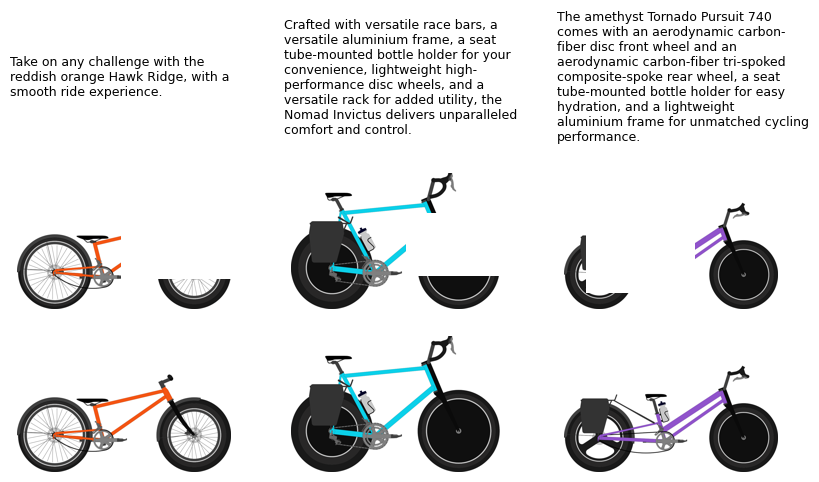

In [5]:
# Visualize 3 masked and complete images side by side
fig, ax = plt.subplots(3, 3, figsize=(10, 6))
for i in range(3):
    wrapped_text = "\n".join(textwrap.wrap(description[i], width=37))  
    ax[0, i].text(0, 0.5, wrapped_text, fontsize=9, va='center')  # Use va='center' and adjust y position
    masked_im = np.moveaxis(masked_images[i], 0, -1)
    im = np.moveaxis(images[i], 0, -1)
    ax[1, i].imshow(masked_im)
    ax[2, i].imshow(im)
    
    # Turn off axes
    ax[0, i].axis("off")
    ax[1, i].axis("off")
    ax[2, i].axis("off")

plt.show()


In case there is any ambiguity about the mask locations, these are provided too. Let's take a look at the mask information for these three bikes. The mask information contains the indices of the edges of the mask (order: left, bottom, right, top). Remember that we count pixels from top to bottom when dealing with numpy arrays.

In [6]:
masks[:3]

array([[ 72, 111, 174,   4],
       [ 29, 101, 159,  14],
       [ 57, 135, 177,  57]])

### Starter Code

In [7]:
#if we just submitted the masked images to predict the complete images:

utils.calculate_error(masked_images[:100], images[:100])

0.09030978632908242

255.0


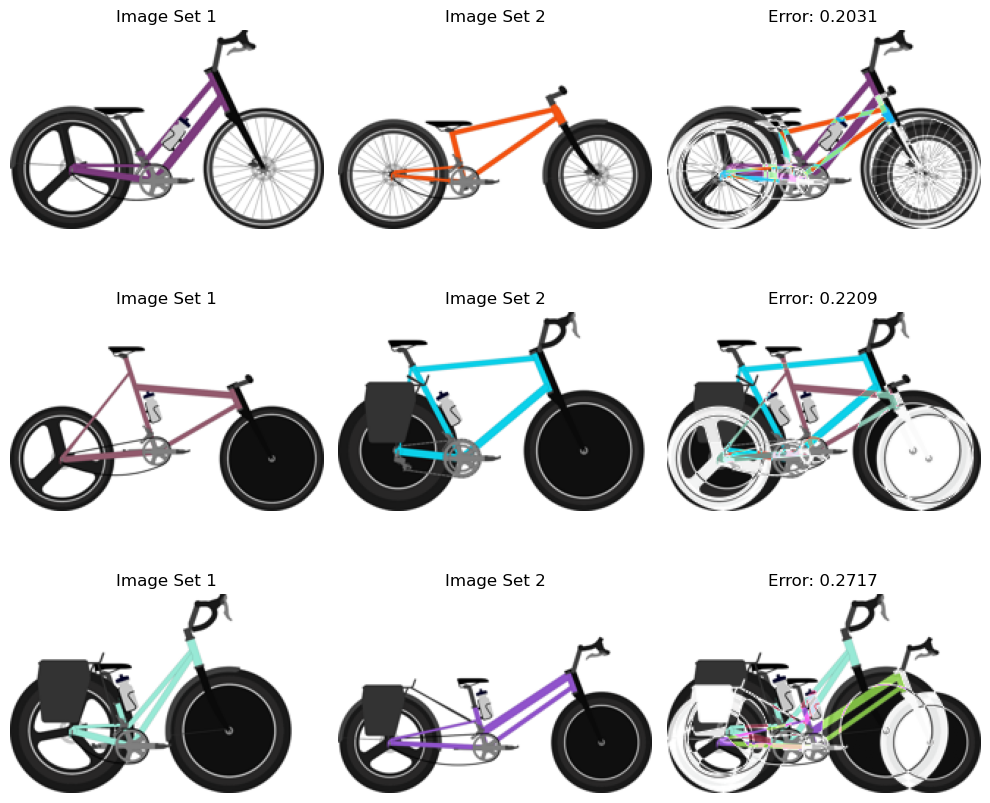

255.0


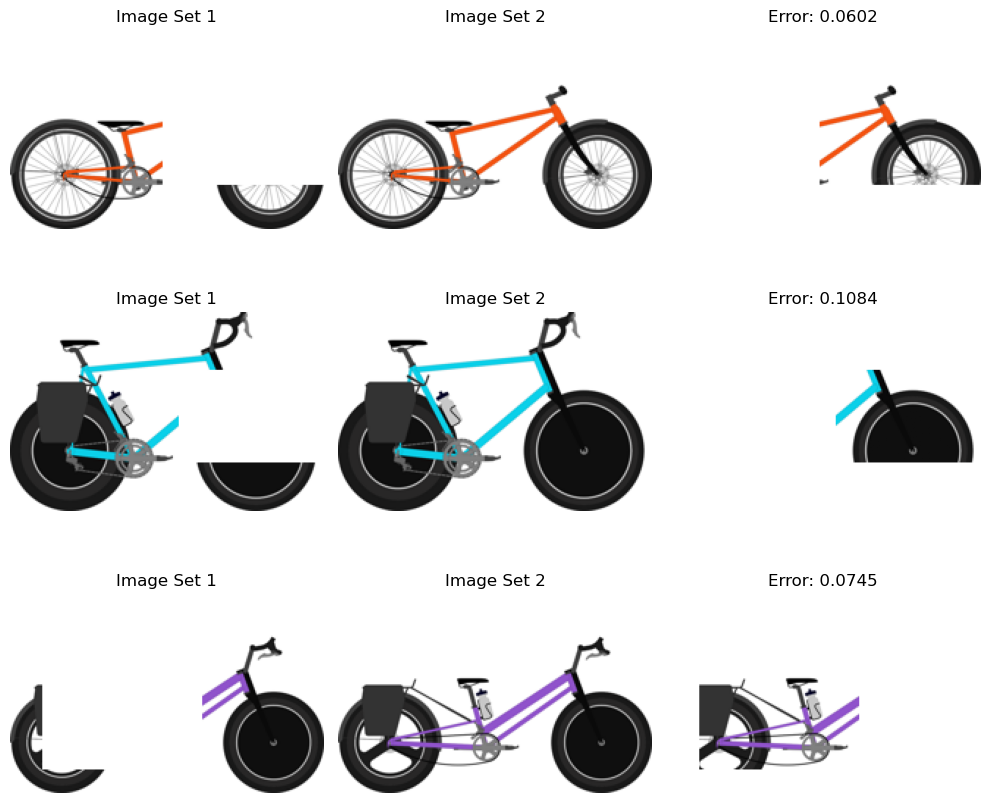

In [8]:

utils.display_images_residual(images[3:6], images[:3])

utils.display_images_residual(masked_images[:3], images[:3])


## How do we fill in the mask of a partial image?? ##

One strategy is to create a VAE that is trained to reconstruct a full image even if we have a partial encoding. To help the VAE identify masked portions of images during training, we can give it an extra feature that segments where an image is masked.

In the function *add_mask_channel()*, a fourth channel is created that passes the value 1 where the *NaN* mask is present in the image. This way, each image has 4 channels: Red, Green, Blue, and Mask.  For our full images, this fourth channel is all zeros. 




In [9]:
#Create a function that takes in a 3 by 136  by 214 image and adds a mask based on NAN values
def add_mask_channel(images):
    img = np.zeros((len(images),4, 136, 214))
    for i in range(images.shape[0]):
        #mask = np.zeros((1, 136, 214))
        mask = np.isnan(images[i])
        mask = mask[0]
        images[i, np.isnan(images[i])] = 0.0
        img[i] = np.concatenate([images[i], mask[None, :, :]], axis=0)
    return img

# Scale the images for machine learning
def scale_images(images):
    images[:,:3,:,:] = images[:,:3,:,:] / 255.0
    return images

#return the image to RGB format
def to_rgb(images):
    img = images[:, :3, :, :]* 255
    return img.astype(np.uint8)

        

In [10]:
# Set the device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [11]:
#format the images

masked_img = add_mask_channel(masked_images)
img = add_mask_channel(images)

masked_img = scale_images(masked_img)
img = scale_images(img)

print(masked_img.shape)
print(img.shape)




(10000, 4, 136, 214)
(10000, 4, 136, 214)


In [12]:

# Convert the numpy arrays to PyTorch tensors
masked_img = torch.tensor(masked_img, dtype=torch.float32)
img = torch.tensor(img, dtype=torch.float32)

# Test-Train split
train_masked, test_masked, train_full,  test_full = train_test_split(masked_img, img, test_size=0.2, random_state=42)


# Create a DataLoader
train_masked = train_masked.to(device)
train_full = train_full.to(device)

train_data = TensorDataset(train_masked, train_full)
Data = DataLoader(dataset=train_data, batch_size=64, shuffle=True)



In [13]:

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=4, stride=2, padding=1),  # -> [N, 16, 68, 107]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16,32, kernel_size=4, stride=2, padding=1),  # -> [N, 32, 34, 53]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # -> [N, 64, 17, 27]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> [N, 128, 8, 13]
            #nn.BatchNorm2d(128),
            #nn.ReLU()
        )
        
        # Fully connected layers for mean and log-variance
        self.fc_mu = nn.Linear(64 * 17 * 27, latent_dim)
        self.fc_logvar = nn.Linear(64 * 17 * 27, latent_dim)
        
        # Decoder fully connected layer
        self.fc_decode = nn.Linear(latent_dim, 64 * 17 * 27)
        
        # Decoder layers
        self.decoder = nn.Sequential(
            #nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # -> [N, 64, 17, 27]
            #nn.BatchNorm2d(64),
            #nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # -> [N, 32, 34, 54]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),    # -> [N, 16, 68, 108]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 4, kernel_size=4, stride=2, padding=1),     # -> [N, 4, 136, 216] #Note: output dimension is supposed to be 136 by 214
            nn.Sigmoid()  # Output pixel values between 0 and 1
        )

    def encode(self, x):
        x = self.encoder(x).view(-1, 64*17*27)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z).view(-1, 64, 17, 27)
        x = self.decoder(x)
        return x[:,:,:,1:-1] #Ensure that the output dimension of the image is 136 by 214

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define loss function
def loss_function(recon_x, x, mu, logvar, beta = 1e-4):
    # Use BCE or MSE as per pixel values; for normalized, use BCE
    recon_loss = torch.nn.L1Loss()(recon_x,x)
    logvar = torch.clamp(logvar, max = 10.0) #clamp logvar to prevent numerical instability
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta*kl_loss/x.size(0)



In [14]:
# Initialize and train the model
model = VAE(latent_dim=64)
model.to(device)

num_epochs = 100


optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    for masked_images, full_images in Data:
        
        #train with masked images in each batch 
        recon_images, mu, logvar = model(masked_images)
        loss_masked = loss_function(recon_images, full_images, mu, logvar)

        optimizer.zero_grad()
        loss_masked.backward()
        optimizer.step()

        #train on the full images in each batch
        recon_images, mu, logvar = model(full_images)
        loss_full = loss_function(recon_images, full_images, mu, logvar)

        optimizer.zero_grad()
        loss_full.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss_full.item():.4f}") 
        

Epoch [0/100], Loss: 0.0958
Epoch [10/100], Loss: 0.0601
Epoch [20/100], Loss: 0.0511
Epoch [30/100], Loss: 0.0489
Epoch [40/100], Loss: 0.0478
Epoch [50/100], Loss: 0.0457
Epoch [60/100], Loss: 0.0439
Epoch [70/100], Loss: 0.0441
Epoch [80/100], Loss: 0.0430
Epoch [90/100], Loss: 0.0440


## Now let's evaluate the model with our validation data ##

Masked images Reconstruction
255.0


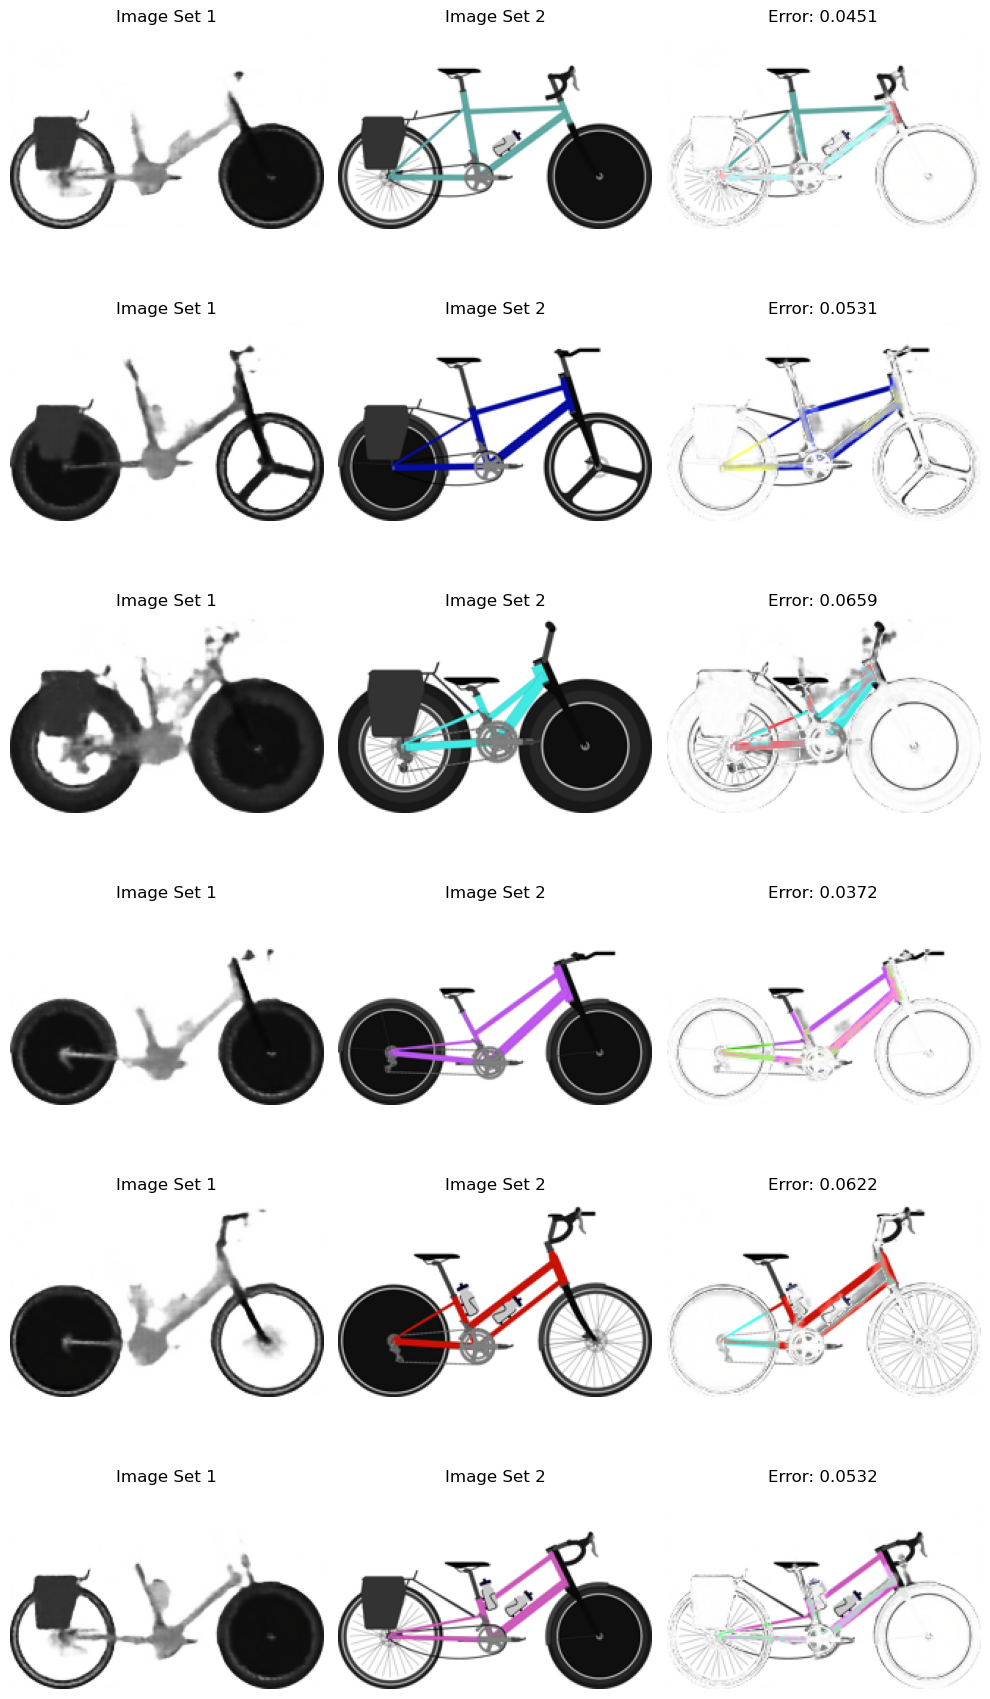

Full images Reconstruction
255.0


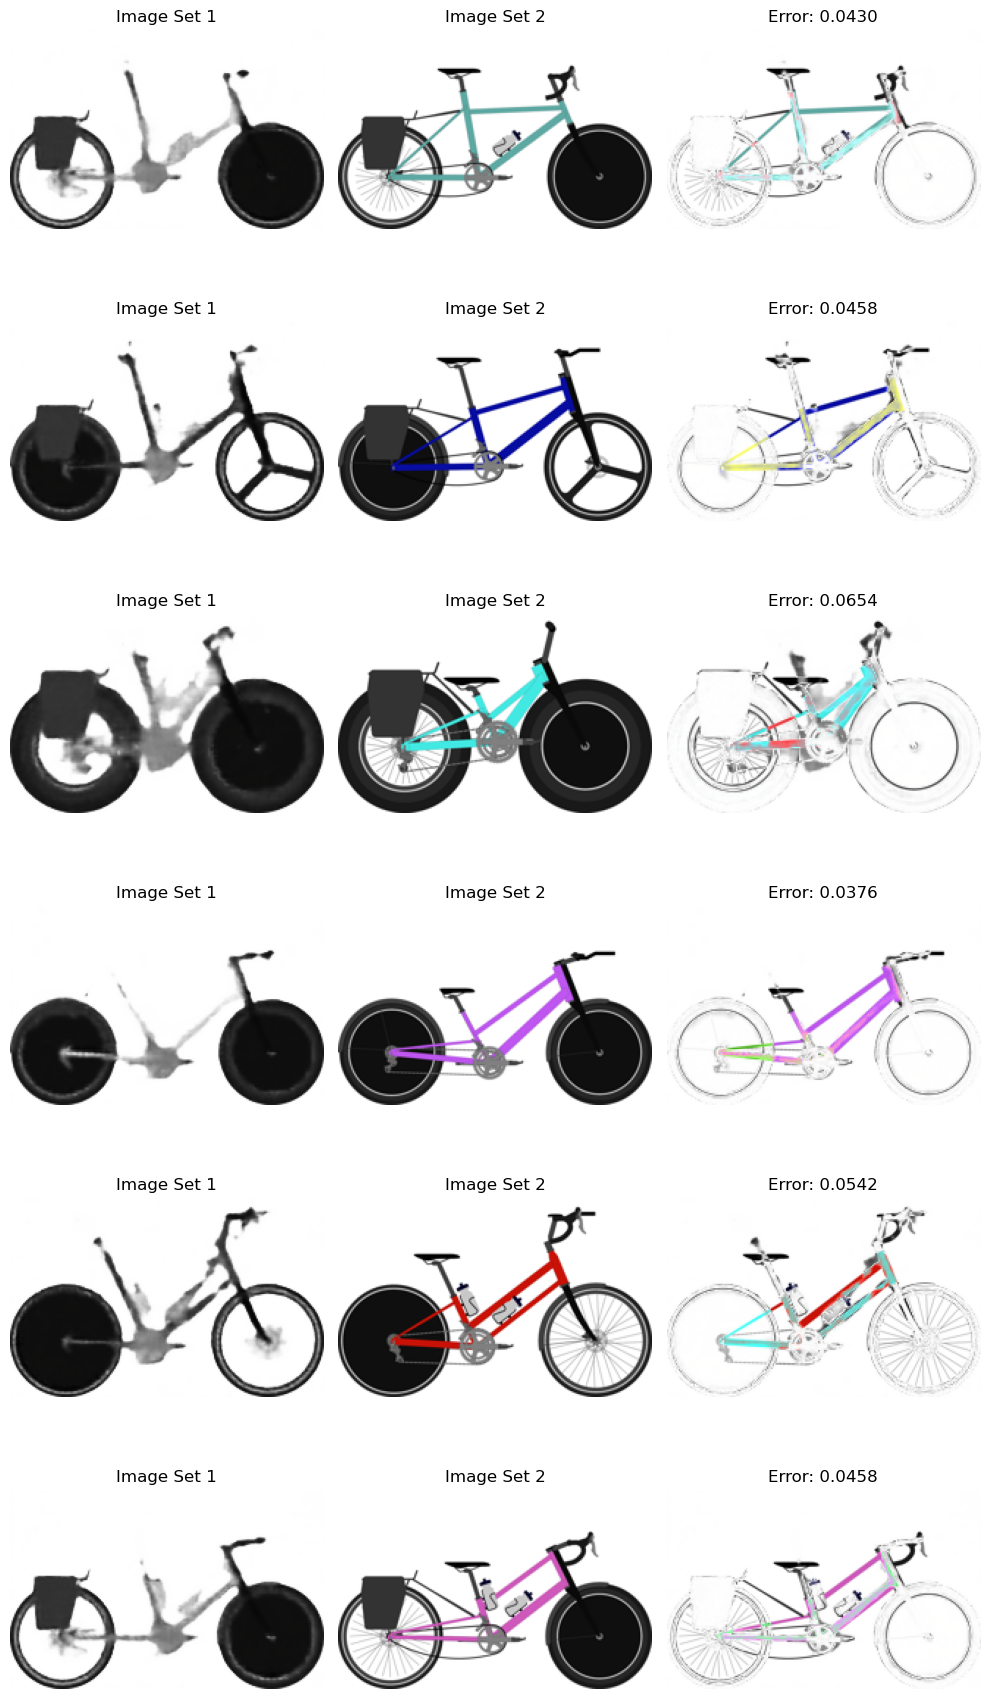

In [23]:
#First let's format some images

mask_img_test = test_masked[0:6].clone().to(device)  
full_img_test = test_full[0:6].clone().to(device)

# Get the reconstructed images
model.eval()
with torch.no_grad():
    recon_masked_images, _, _ = model(mask_img_test)
    recon_full_images, _, _ = model(full_img_test)

#Now let's convert the first 3 images to RGB format and display them
recon_masked_images = to_rgb(recon_masked_images.detach().cpu().numpy())
recon_full_images = to_rgb(recon_full_images.detach().cpu().numpy())

img_ground_truth = to_rgb(full_img_test.detach().cpu().numpy())



# Display the first 3 images
print("Masked images Reconstruction")
utils.display_images_residual(recon_masked_images, img_ground_truth)

print("Full images Reconstruction")
utils.display_images_residual(recon_full_images, img_ground_truth)




Masked vs Full images Reconstruction
237.0


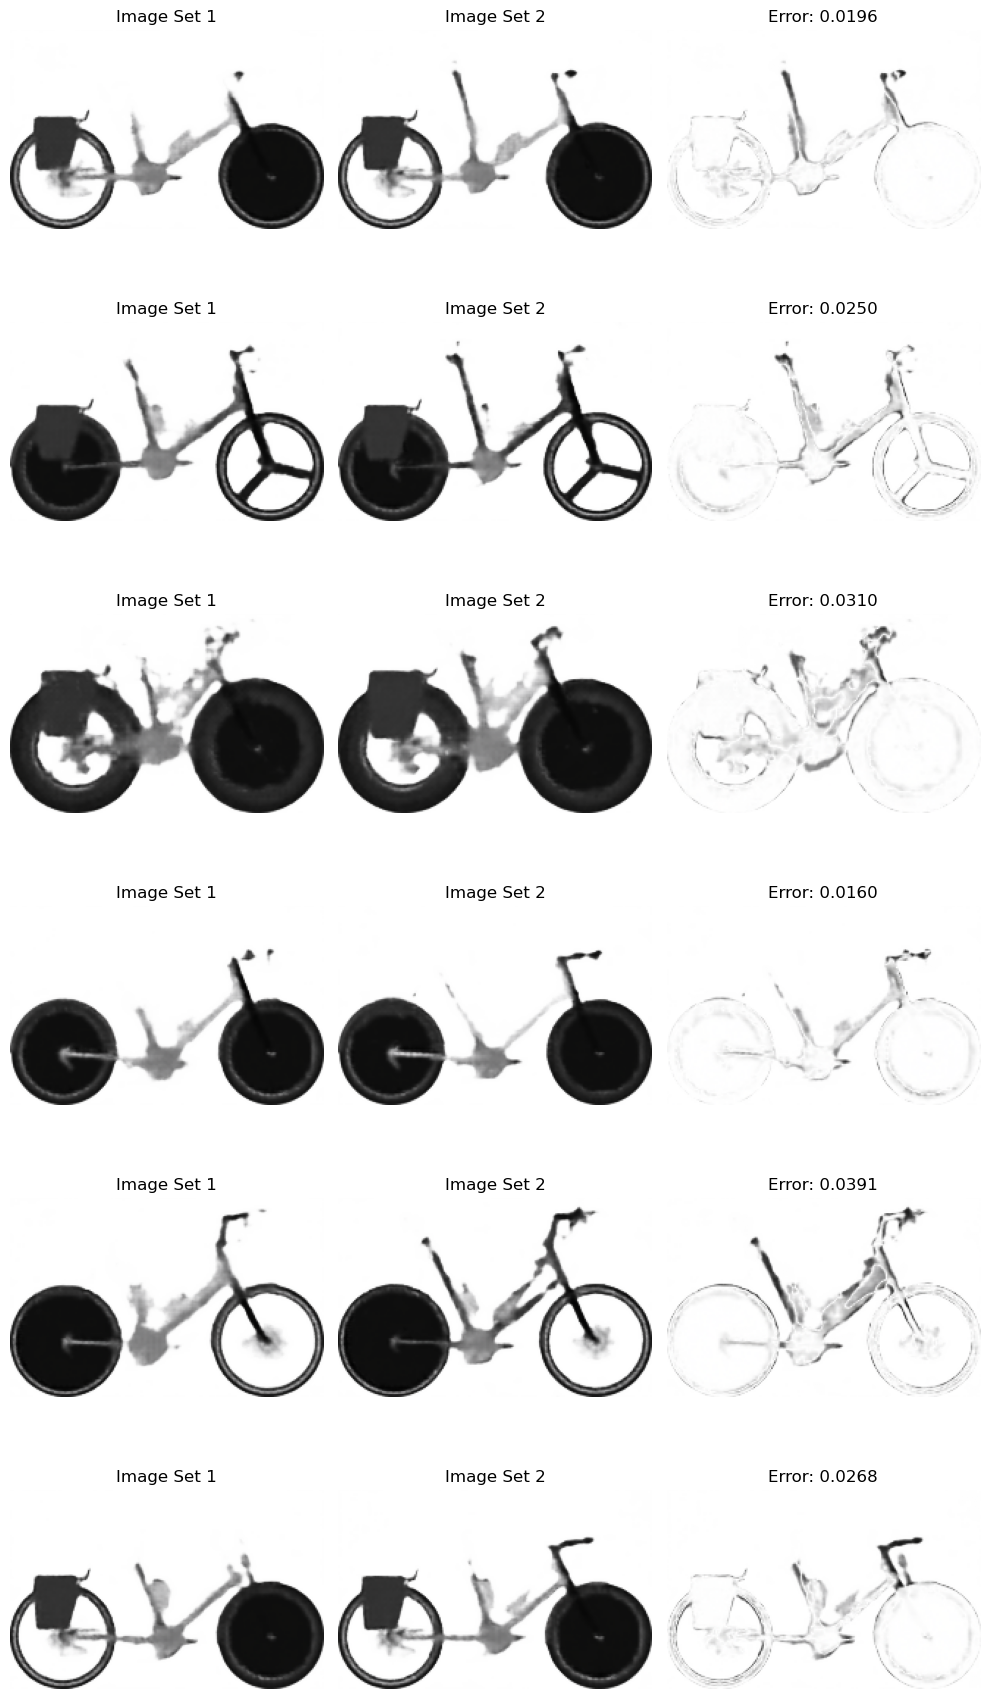

In [25]:

print("Masked vs Full images Reconstruction")
# Compare the error between a reconstruction of the masked images and the full images
utils.display_images_residual(recon_masked_images, recon_full_images)


## How can I improve this model?? ##

Your job is is create better sample images given the masked data. Some strategies that the TA's recommend trying are: 

1) Build another type of deep generative model, such as a GAN or Diffusion Model. Please ask the TA's for sample code or use the code from the demo! Diffusion models are the state of the art DGM for image synthesis and they will provide the highest quality images for this challenge problem. We highly recommend trying this approach!

2) Create more masked images (and even create several masked samples for each image in the training data)

3) Utilize the masked parametric information to explore how the parametric data can improve image quality

4) Change/modify the loss functions to consider the error in the latent embedding between a masked image and its respective full image.

5) Implement a model that leverages information from the text descriptions to improve the image quality. 

6) Implemet a beta scheduler to adjust the influence of the KL 


### Prepare your Submission

In [16]:
masked_images_test, masks_test, parametric_test, description_test, _ = utils.load_data("test") # images_test is not provided. You need to predict image_test. 

Make sure your data is scaled correctly! We expect your images to be scaled from 0-255. 